# Introduction to Chainer&#58; Neural Networks in Python


Neural networks provide a vast array of functionality in the realm of statistical modeling, from data transformation to classification and regression. Unfortunately, due to the computational complexity and generally large magnitude of data involved, the training of so called *deep learning* models has been historically relegated to only those with considerable computing resources. However with the advancement of GPU computing, and now a large number of easy-to-use frameworks, training such networks is fully accessible to anybody with a simple knowledge of Python and a personal computer. In this post we'll go through the process of training your first neural network in Python using an exceptionally readable framework called [Chainer](http://chainer.org).

 

 We'll start by making one of the simplest neural networks possible, a linear regression. Then we'll move into more complex territory by training a model to classify the MNIST hand written digits dataset (a standard benchmark for deep learning models). 


Should you wish to execute the code examples below, you will need to install chainer, matplotlib, and numpy. These are easily installed through the Python package manager, `pip`. 

```
$ pip install numpy
$ pip install matplotlib
$ pip install chainer

```

Also, please make sure to upgrade your version of Cython if you have previously installed it or have it installed via Anaconda or you may receive a cryptic error during the Chainer installation process. 

```
$ pip install --upgrade cython

``` 


## Part 1: Basics of Chainer



To start, we will begin with a discussion of the three basic objects in Chainer, the `chainer.Function`, `chainer.Optimizer` and the `chainer.Variable`. 



First we need to import a few things, which will be used throughout the notebook, including matplotlib, numpy, and some chainer specific modules we will cover as we go.

In [1]:
#Matplotlib and NumPy
import numpy as np
import matplotlib.pyplot as plt

#plotting tweaks
%matplotlib inline
label_size = 20
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'], mpl.rcParams['ytick.labelsize'] = label_size , label_size


#Chainer Specific
from chainer import FunctionSet, Variable, optimizers, serializers
import chainer.functions as F
import chainer.links as L

### Examining Chainer Variables and Functions

Let's begin by making two chainer variables, which are just wrapped NumPy arrays, named `a` and `b`. We'll make them one value arrays, so that we can do some scalar operations with them. 

In [2]:
# Create 2 chainer variables then sum their squares
# and assign it to a third variable.
a = Variable(np.array([3], dtype=np.float32))
b = Variable(np.array([4], dtype=np.float32))
c = a**2 + b**2

In Chainer, `Variable` objects are both part symbolic and part numeric. They contain values in the `data` attribute, but also information about the chain of operations that has been performed on them. This history is extremely useful when trying to train neural networks because by calling the `backward()` method on a variable we can perform backpropagation or (reverse-mode) auto-differentiation, which provides our chosen optimizer with all the information needed to successfully update the weights of our neural networks.

This process can happen, because chainer variables store the sequence of chainer functions that act upon them and each function contains an analytic expression of its derivative. Some functions you will use will be parametric and contained in `chainer.links` (imported here as `L`). These types of functions are the ones whose parameters will be updated with each training iteration of our network. Other functions will be non-parametric, contained in `chainer.functions` (imported here as `F`), and merely perform a predefined mathematical operation on a variable. Even the addition and subtraction operations are promoted to chainer functions and the history of operations of each variable is stored as part of the variable itself. This allows us to calculate derivatives of any variable with respect to any another.

Let's see how this works by example. Below we will:

1. Inspect the value of our previously defined variables above by using the data attribute.

2. Backpropagate using the `backward()` method on the third variable, `c`.

3. Inspect the derivatives of the variables stored in the `grad` attribute. 


In [3]:
# Inspect the value of your variables.
print("a.data: {0}, b.data: {1}, c.data: {2}".format(a.data, b.data, c.data))

a.data: [ 3.], b.data: [ 4.], c.data: [ 25.]


In [4]:
# Now call backward() on the sum of squares.

c.backward()


# And inspect the gradients.

print("dc/da = {0}, dc/db = {1}, dc/dc = {2}".format(a.grad, b.grad, c.grad))

dc/da = [ 6.], dc/db = [ 8.], dc/dc = [ 1.]


## Part 2: Doing Linear Regression in Chainer

Now that we know a little bit about the basics of what Chainer is doing, let's use it to train the most basic possible neural network, a linear regression network. Of course the solution to the least squares optimization involved here can be calculated analytically via the normal equations much more efficiently, but this process will demonstrate the basic components of each network you'll train going forward. 

This network has no *hidden* units and involves just one input node, one output node, and a linear function linking the two of them. 


To train our regression we will go through the following steps: 

1. Generate random linearly dependent datasets.

2. Construct a function to perform a forward pass through the network with a chainer Link.

3. Make a function to do the network training. 

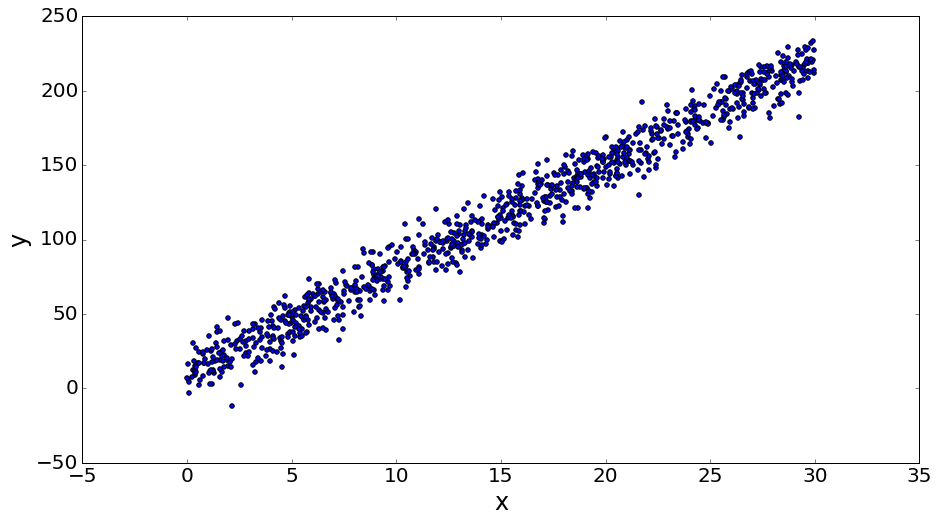

In [5]:
# Generate linearly related datasets x and y. 
plt.figure(figsize=(15,8))
x = 30*np.random.rand(1000).astype(np.float32)
y = 7*x+10
y += 10*np.random.randn(1000).astype(np.float32)

plt.scatter(x,y)
plt.xlabel('x', fontsize=24)
plt.ylabel('y', fontsize=24)

In general, the structure you'll want to keep common to all neural networks that you make in Chainer involves making a `forward` function, which takes in your different parametric link functions and runs the data through them all in sequence.

Then writing a `train` function, which runs that forward pass over your batches of data for a number of full passes through the data called *epochs*, and then after each forward pass calculates a specified loss/objective function and updates the weights of the network using an `optimizer` and the gradients calculated through the `backward` method. 


At the start Chainer practitioners often define the structure they'll be working with by specifying the Link layers (here we'll only need one). Then they will specify an optimizer to use, by instantiating one of the optimizer classes. Finally, they'll tell the optimizer to keep track of and update the parameters of the specified model layers by calling the setup method on the optimizer instance with the layer to be tracked as an argument.


In [6]:
# Setup linear link from one variable to another.

linear_function = L.Linear(1,1)

# Set x and y as chainer variables, make sure to reshape 
# them to give one value at a time.
x_var = Variable(x.reshape(1000,-1))
y_var = Variable(y.reshape(1000,-1))

# Setup the optimizer.
optimizer = optimizers.MomentumSGD(lr=0.001)
optimizer.setup(linear_function)

# Define a forward pass function taking the data as input.
# and the linear function as output.
def linear_forward(data):
    return linear_function(data)


# Define a training function given the input data, target data,
# and number of epochs to train over. 
def linear_train(train_data, train_target,n_epochs=200):
    
    for _ in range(n_epochs):
        # Get the result of the forward pass.    
        output = linear_forward(train_data)

        # Calculate the loss between the training data and target data.
        loss = F.mean_squared_error(train_target,output)

        # Zero all gradients before updating them.
        linear_function.zerograds()

        # Calculate and update all gradients.
        loss.backward()

        # Use the optmizer to move all parameters of the network
        # to values which will reduce the loss. 
        optimizer.update()

### Plot Results During Training

The code below will train the model for 5 epochs at a time and plot the line which is given by the current network parameters in the linear link. You can see how the model converges to the correct solution as the line starts out as light blue and moves toward its magenta final state.

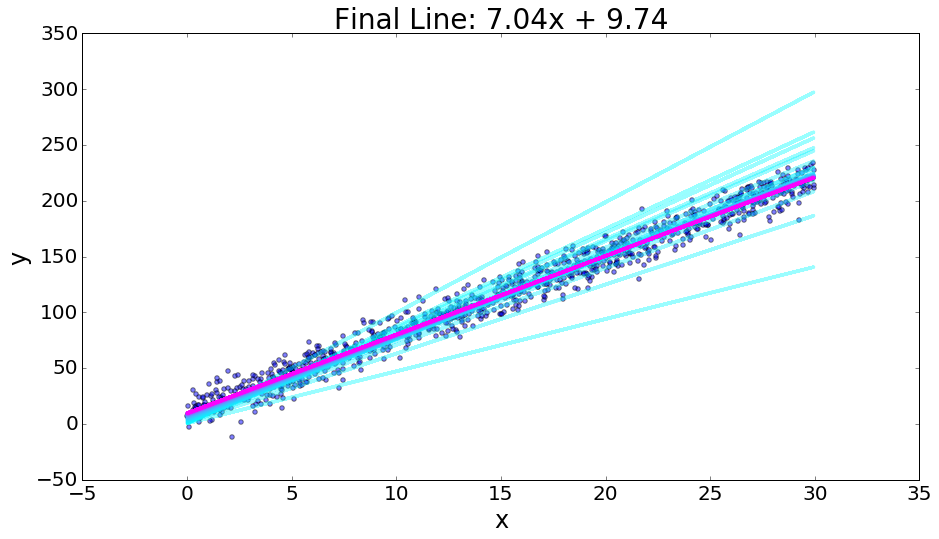

In [7]:
# This code is supplied to visualize your results.
plt.figure(figsize=(15,8))
plt.scatter(x,y, alpha =0.5)

for i in range(150):    
    linear_train(x_var, y_var, n_epochs=5)
    y_pred = linear_forward(x_var).data
    plt.plot(x, y_pred, color=plt.cm.cool(i/150.), alpha = 0.4, lw =3)
    
    
slope = linear_function.W.data[0,0]
intercept = linear_function.b.data[0]
plt.title("Final Line: {0:.3}x + {1:.3}".format(slope, intercept), fontsize=28)
plt.xlabel("x", fontsize=24)
plt.ylabel("y", fontsize=24)

### BONUS POINTS 
If you've been following along doing your own code executions, try turning the above linear regression into a logistic regression. Use the following binary dataset for your dependent variable.

```python
y_log = y>y.mean()

y_var = Variable(y_log.astype(np.int32).reshape(1000,-1))
```

#### HINT 
You'll want to make use of the `F.sigmoid()` and `F.sigmoid_cross_entropy()` functions.


## Part 3: Train a Handwritten Digit Classifier

For this third and final part we will use the MNIST handwritten digit dataset and try to classify the correct numerical value written in a \\(28\times28\\) pixel image. This is a classic benchmark for supervised deep learning architectures.

For this problem we will alter our simple linear regressors by now including some *hidden* linear neural network layers as well as introducing some non-linearity through the use of a non-linear *activation function*. This type of architecture is called a [Multilayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP), and has been around for quite some time. Let's see how it performs on the task at hand. 

The following code will take care of the downloading, importing, and structuring of the MNIST set for you so that you can just focus on your network architecture, but feel free to ask questions if something about that process isn't clear. In order for this to work, you'll need to download this [`data.py`](https://raw.githubusercontent.com/pfnet/chainer/master/examples/mnist/data.py) file from the Chainer [github repository](https://github.com/pfnet/chainer) and place it in the root directory of your script/notebook.

In [8]:
# functions for importing the MNIST dataset.
import data


# We'll first import the data as a variable mnist.
# (If this is the first time you've run this function
# it could take a minute or two)


mnist = data.load_mnist_data()

Now let's inspect the images to see what they look like. 

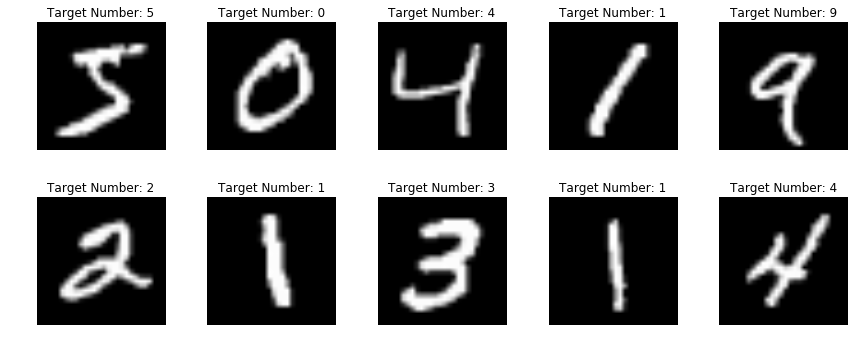

In [9]:
plt.figure(figsize=(12,5))
for i in range(10):
    example = mnist['data'][i].reshape(28, 28)
    target = mnist['target'][i]
    plt.subplot(2, 5, i+1)
    plt.imshow(example, cmap='gray')
    plt.title("Target Number: {0}".format(target))
    plt.axis("off")
plt.tight_layout()

Finally, we will separate the feature and target datasets and then make a train/test in order to properly validate the model at the end. 

In [10]:
# Separate the two parts of the MNIST dataset
features = mnist['data'].astype(np.float32) / 255
targets = mnist['target'].astype(np.int32)

# Make a train/test split. 
x_train, x_test = np.split(features, [60000])
y_train, y_test = np.split(targets, [60000])

With that out of the way, we can focus on training our MLP. Like it's namesake implies, the MLP has a number of different layers and Chainer has a nice way to wrap up the layers of our network so that they can all be bundled together into a single object. 

### The FunctionSet <a name="footnote1-return"></a><sup><a href="#footnote1">1</a></sup>

This handy object takes keyword arguments of named layers in the network so that we can later reference them. It works like this.

```
model = FunctionSet(layer1=<place link here>, layer2=<place link here>, ...etc.)
```

Then the layers exist as properties of the class instance and all can be simultaneously told to be optimized by feeding the FunctionSet instance to the optimizers setup method:
```
optimizer.setup(model)
```

With that tip, let's move on to structuring our classifier. We need to get from a \\(28\times28\\) pixel image down to a 10-dimenisional [simplex](https://en.wikipedia.org/wiki/Simplex) (where all the numbers in the output sum to one). In the output each dimension will represent a probability of the image being a specific digit according to our MLP classifier. 

### The MLP Structure


To make it simple here, let's start by including only 3 link layers in our network (you should feel free to mess around with this at your leisure later though to see what changes make for better classifier performance).


We'll need a link taking the input images which are \\(28 \times 28=784\\) down to some other (probably lower) dimension, then a link stepping down the dimension even further, and finally we want to end up stepping down to the 10 dimensions at the end (with the constraint that they sum to 1).

Additionally, since compositions of [linear functions](https://en.wikipedia.org/wiki/Linear_function) are linear and the benefit of deep learning models are their ability to approximate arbitrary nonlinear functions, it wouldn't do us much good to stack repeated linear layers together without adding some nonlinear function to send them through</a><sup><a href="#footnote2">2</a></sup>.

So the forward pass we want will alternate between a linear transformation between data layers and a non-linear [*activation function*](https://en.wikipedia.org/wiki/Activation_function). In this way the network can learn non-linear models of the data to (hopefully) better predict the target outcomes. Finally, we'll use a [softmax](https://en.wikipedia.org/wiki/Softmax_function) [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss function</a><sup><a href="#footnote3">3</a></sup> to compare the vector output of the network to the integer target and then backpropagate based on the calculated loss. 


Thus the final forward pass structure will look like:

    out = linear_layer1(data)
    out = relu(out)
    out = linear_layer2(out)
    out = relu(out)
    out = linear_layer3(out)
    
And when it comes time to train our model, with this size of data, we'll want to batch process a number of samples and aggregate their loss collectively before updating the weights.
    
#### Define the Model

To start we define the model by declaring the set of links and the optimizer to be used during training.

In [11]:
# Declare the model layers together as a FunctionSet
mnist_model = FunctionSet(
                                  linear1=L.Linear(784, 300),
                                  linear2=L.Linear(300, 100),
                                  linear3=L.Linear(100, 10)
                         )

# Instantiate an optimizer (you should probably use an
# Adam optimizer here for best performance)
# and then setup the optimizer on the FunctionSet.
mnist_optimizer = optimizers.Adam()
mnist_optimizer.setup(mnist_model)

#### Construct Training Functions

Now we construct the proper functions to structure the forward pass, define the batch processing for training, and predict the number represented in the MNIST images after training. 

In [12]:
# Construct a forward pass through the network,
# moving sequentially through a layer then activation function
# as stated above.
def mnist_forward(data, model):
    
    out1 = model.linear1(data)
    out2 = F.relu(out1)
    out3 = model.linear2(out2)
    out4 = F.relu(out3)
    final = model.linear3(out4)
    return final



# Make a training function which takes in training data and targets
# as an input. 
def mnist_train(x, y, model, batchsize=1000, n_epochs=20):
    
    data_size = x.shape[0]
    # loop over epochs
    for epoch in range(n_epochs):
        print('epoch %d' % (epoch + 1))
        
        # randomly shuffle the indices of the training data
        shuffler = np.random.permutation(data_size)
        
        # loop over batches
        for i in range(0, data_size, batchsize):
            x_var = Variable(x[shuffler[i : i + batchsize]])
            y_var = Variable(y[shuffler[i : i + batchsize]])
            
            output = mnist_forward(x_var, model)
            model.zerograds()
            loss = F.softmax_cross_entropy(output, y_var)
            loss.backward()
            mnist_optimizer.update()

# Make a prediction function, using a softmax and argmax in order to
# match the target space so that we can validate. 
def mnist_predict(x, model):
    x = Variable(x)
    
    output = mnist_forward(x, model)
    
    return F.softmax(output).data.argmax(1)

#### Train the Model 

We can now train the network (I'd recommend a low number of epochs and a high batch size to start with in order to reduce training time, then these can be altered later to increase validation performance).

In [13]:
mnist_train(x_train, y_train, mnist_model, n_epochs=5)

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5


#### Make a Prediction

The last thing we must do is validate the model on our held out set of test images to make sure that the model is not overfitting. 

In [14]:
# Call your prediction function on the test set
pred = mnist_predict(x_test, mnist_model)

# Compare the prediction to the ground truth target values.
accuracy = (pred==y_test).mean()

# Print out test accuracy
print("Test accuracy: %f" % accuracy)

Test accuracy: 0.967900


Thus, by simply training for around 5 epochs</a><sup><a href="#footnote4">4</a></sup> we obtain a model that has an error rate of only 3.6% in testing!


### Model Persistence

Should you wish to save your trained model for future use, Chainer's most recent release provides the ability to serialize link elements and optimizer states into an hdf5 format via:

In [15]:
serializers.save_hdf5('test.model', mnist_model)
serializers.save_hdf5('test.state', mnist_optimizer)

Then we can quickly restore the state of our previous model and resume training from that point by loading the serialized files.

```python 

serializers.load_hdf5('my_model.model', model_name)
serializers.load_hdf5('my_optimizer.state', optimizer_name)
```

## Conclusion

Over the course of this post you have hopefully gained an appreciation for the utility of using neural network frameworks like Chainer. It's worth noting that the entire routine we developed for structuring and training a high-performance MNIST classifier with a 3.6% error rate was accomplished in just over 25 lines of code and around 10 seconds of CPU training time, in which it processed a total of 300,000 images. Of course, in my effort to prioritize simplicity I have opted for readability over elegance. Thus, many of the techniques above should be altered in practice beyond the learning stage. The [Chainer documentation](http://docs.chainer.org/en/stable/) is rather extensive and covers both best practices and more advanced topics in greater detail, including modularity through object orienting. 


---------------------------------


<span style="font-size:medium;">
<a name="footnote1"></a>
<sup>1</sup>
FunctionSet is now depricated in the most recent Chainer release, with the preferred alternative being to make your own class that inherits from the chainer Chain class. However, in the interest of making this post as simple as possible I've opted to use the older method and wrap the links with FunctionSet. You should refer to Chainer's own <a href="http://docs.chainer.org/en/stable/tutorial/basic.html" target="_blank">tutorial documentation</a>  for a more elegant treatment.
<a href="#footnote1-return">&larr;</a>
</span>

<span style="font-size:medium;">
<a name="footnote2"></a>
<sup>2</sup>
We'll use [rectified linear units](https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29) for this example due to their computational efficiency and easy backpropagation.
<a href="#footnote2-return">&larr;</a>
</span>


<span style="font-size:medium;">
<a name="footnote3"></a>
<sup>3</sup>
This will help impose the constraint that the output values should sum to one. 
<a href="#footnote3-return">&larr;</a>
</span>

<span style="font-size:medium;">
<a name="footnote4"></a>
<sup>4</sup>
This process takes under 10 seconds on my 3.1 GHz dual-core i7. 
<a href="#footnote4-return">&larr;</a>
</span>
